## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> TP1 INF8460 <br>  Automne 2021 </center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import nltk as nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import re
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

#A MODIFIER
os.chdir('/content/drive/My Drive/POLY/INF8460/TPS/TP1')
#os.chdir('/content/drive/My Drive/TP1')
t_init = time.time()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. DESCRIPTION
Dans ce TP, l’idée est d’effectuer de la recherche de passages de texte dans un corpus à partir d’une question en langue naturelle. Les questions et passages sont en anglais.

Voici un exemple : <br>
__Entrée : Question :__ What causes precipitation to fall?  

__Solution - Trouver un passage qui contient la réponse à la question :__ In meteorology, precipitation is any product of the condensation of atmospheric water vapor that falls under <mark> __gravity__ </mark>. The main forms of precipitation include drizzle, rain, sleet, snow, graupel and hail... Precipitation forms as smaller droplets coalesce via collision with other rain drops or ice crystals within a cloud. Short, intense periods of rain in scattered locations are called “showers”. 

Ici la réponse est en gras dans le texte.

## 2. LIBRARIES PERMISES
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- Pour toute autre librairie, demandez à votre chargé de laboratoire


## 3. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)

## 4. DESCRIPTION DES DONNEES

Dans ce projet, vous utiliserez le jeu de données dans le répertoire _data_. Il est décomposé en données d’entrainement (train), de validation (dev) et de test (test). <br>

Nous ne mettrons à votre disposition que les données d’entrainement et de validation. Les données de test ne contiennent pas le paragraphe de réponse et doivent être complétées avec les résultats de votre système.
Nous vous fournissons un ensemble de données qui comprend un corpus (_corpus.csv_) qui contient tous les passages et leurs identificateurs (ID) et un jeu de données qui associe une question, un passage, et une réponse qui est directement extraite du passage. Notez que certains passages contiennent des balises HTML et qu’il vous faudra procéder à un prétraitement de ces passages pour les enlever. <br>
Ce jeu de données est composé de trois sous-ensembles : 
- _Train_ : ensemble d’entraînement de la forme <QuestionID, QuestionText, PassageID, Réponse>. Le but est donc d’entrainer votre modèle à retrouver le passage qui contient la réponse à la question.
- _Validation_ : De la même forme que le Train, il vous permet de valider votre entraînement et de tester les performances de certains modules.  
- _Test_ : Un ensemble secret qui est utilisé pour évaluer votre système complet. Il est de la forme <QuestionID, Question>. Votre système doit trouver dans le corpus __corpus.csv__ le ou les passages les plus pertinents.

Notez qu’il est possible de répondre aux requis du TP sans utiliser la réponse à la question. C’est à vous de choisir si vous utilisez la réponse ou non. 

## 5. ETAPES DU TP 
A partir du notebook _inf8460_A21_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Noter que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

Ci-dessous définir la constante _PATH_ qui doit être utilisée par votre code pour accéder aux fichiers. Il est attendu que pour la correction, le chargé de lab n'ait qu'à changer la valeur de _PATH_ pour le répertoire où se trouver les fichiers de datasets.

In [ ]:
PATH = "data/"

### 5.1. Pré-traitement (12 points)
Les passages et questions de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de passage pour répondre à une question. On vous demande donc d’implémenter une étape de pré-traitement des données.
1) (_6 points_) Complétez les fonctions retournant les informations suivantes (une fonction par information, chaque fonction prenant en argument le corpus (passages, questions) composé d'une liste de phrases segmentées en jetons/tokens) :
    1. Le nombre total de jetons (mots non distincts)
    2. Le nombre total de mots distincts (les types qui constituent le vocabulaire)
    3. Les N mots les plus fréquents du vocabulaire (N est un paramètre avec une valeur par défaut de 10) ainsi que leur fréquence
    4. Le ratio jeton/type
    5. Le nombre total de lemmes distincts
    6. Le nombre total de racines (stems) distinctes

In [ ]:
# Fonction de prétraitement pour retirer les balises html
def remove_html(string):
  return re.sub("\\<[^>]*>","", string)

# Fonction utile pour transformer une liste de sous listes en une seule liste contenant tout les items de ces sous listes
def flatten(t):
    return [item for sublist in t for item in sublist]

#1. Le nombre total de jetons (mots non distincts)
def nb_jetons(corpus):
  c = flatten(corpus)
  fdist = FreqDist(c)
  return sum(fdist.values())

#2. Le nombre total de mots distincts (les types qui constituent le vocabulaire)
def nb_distincts(corpus):
  c = flatten(corpus)
  fdist = FreqDist(c)
  return len(fdist)

#3. Les N mots les plus fréquents du vocabulaire (N est un paramètre avec une valeur par défaut de 10) ainsi que leur fréquence
def Nfreq(corpus, N=10):
  c = flatten(corpus)
  fdist = FreqDist(c)
  sortedDict = sorted(fdist.items(), key=lambda x: x[1], reverse=True)
  return sortedDict[:N]

#4. Le ratio jeton/type
def ratio(corpus):
  return nb_jetons(corpus)/nb_distincts(corpus)

#5. Le nombre total de lemmes distincts 
def lemme_dist(corpus):
  c = flatten(corpus)
  lemmzer = nltk.WordNetLemmatizer()
  a = [lemmzer.lemmatize(token) for token in c]
  return len(set(a))

#6. Le nombre total de racines (stems) distinctes
def stem_dist(corpus):
  c = flatten(corpus)
  stemmer = nltk.PorterStemmer()
  a = [stemmer.stem(token) for token in c]
  return len(set(a))

2. (_1 point_) Ecrivez une fonction explore_corpus() qui fait appel à toutes les fonctions en 1) et imprime leur résultat.


In [ ]:
def explore_corpus(corpus):
  print("Le nombre total de jetons : ", nb_jetons(corpus),"\n")
  print("Le nombre total de mots distincts : ", nb_distincts(corpus),"\n")
  print("Les N mots les plus fréquents du vocabulaire : ", Nfreq(corpus),"\n")
  print("Le ratio jeton/type : ", ratio(corpus),"\n")
  print("Le nombre total de lemmes distincts : ", lemme_dist(corpus),"\n")
  print("Le nombre total de racines distinctes : ", stem_dist(corpus),"\n")

In [ ]:
# Récupération des paragraphes
corpus = pd.read_csv( "./data/corpus.csv")
corpus_size = len(corpus)
corpus

,id,paragraph
0,0,The Normans (Norman: Nourmands; French: Norman...
1,1,"The Norman dynasty had a major political, cult..."
2,2,"The English name ""Normans"" comes from the Fren..."
3,3,"In the course of the 10th century, the initial..."
4,4,"Before Rollo's arrival, its populations did no..."
...,...,...
83322,83322,<P> Reevis ' first movie job was as a stunt ri...
83323,83323,<P> `` Up on Cripple Creek '' is the fifth son...
83324,83324,<P> The fifth season of the American televisio...
83325,83325,<P> Footballer Danny Blanchflower turned down ...


In [ ]:
# Récupération des questions d'entrainement
train_corpus = pd.read_csv( "./data/train_ids.csv")
train_size = len(train_corpus)
train_corpus

,Unnamed: 0,id,question,paragraph_id,answer
0,0,0,Who leaders the sub-divisions of offices or di...,7544.0,deputy assistant directors
1,1,1,Besides using 3kV DC what other power type is ...,16461.0,25 kV 50 Hz AC
2,2,2,How many other cities had populations larger t...,11041.0,Twenty-two
3,3,3,Did von Neumann rule hidden variable theories?,14002.0,von Neumann did not claim that his proof compl...
4,5,5,What is the name of the book that has the laws...,6848.0,Torah
...,...,...,...,...,...
87296,106171,106171,who played annie's dad on 7th heaven,30072.0,Graham Jarvis
87297,106172,106172,where is the gallbladder situated in our body,76550.0,beneath the liver
87298,106173,106173,who believed that human ability is due to a co...,73560.0,Francis Galton
87299,106174,106174,when is bachelor in paradise airing in australia,37241.0,25 March 2018


In [ ]:
# Récupération des questions de test
test_corpus = pd.read_csv( "./data/test.csv")
test_size = len(test_corpus)
test_corpus

,id,question
0,0,How much sythetic cotton was produced worldwid...
1,1,What Epic tells how to make beer?
2,2,Some authorities reverse terminologies to refe...
3,3,When did part of Spain separate from the Nethe...
4,4,When do birds substantially increase body fats...
...,...,...
9995,9995,who votes for rookie of the year mlb
9996,9996,who gave national film fare award in india
9997,9997,when did captain america winter soldier take p...
9998,9998,who does samantha end up with on er


In [ ]:
# Récupération des questions de validation
validation_corpus = pd.read_csv( "./data/val_ids.csv")
validation_size = len(validation_corpus)
validation_corpus

,Unnamed: 0,id,question,paragraph_id,answer
0,0,0,What is the oldest piece of Qutb Shahi archite...,17134.0,the ruins of Golconda fort
1,2,2,What is a popular grain source for brewing bee...,6902.0,agave
2,3,3,On what digital platform were contestants perf...,2178.0,iTunes
3,5,5,Who were the two most powerful nations in the ...,10150.0,Kingdom of Prussia and the Austrian Empire
4,6,6,Kanye has stated that members from which rap g...,1928.0,Wu-Tang Clan
...,...,...,...,...,...
8170,9995,9995,who played charlene darling in the andy griffi...,47863.0,Maggie Peterson Mancuso
8171,9996,9996,who designed the world war ii memorial in wash...,52591.0,Friedrich St. Florian
8172,9997,9997,what is walter white's middle name in breaking...,22966.0,Hartwell
8173,9998,9998,the kushites of meroe had indirect trade relat...,38988.0,Rome


In [ ]:
# Remove html
corpus['paragraph'] = corpus['paragraph'].apply(remove_html)
train_corpus['question'] = train_corpus['question'].apply(remove_html)
validation_corpus['question'] = validation_corpus['question'].apply(remove_html)
test_corpus['question'] = test_corpus['question'].apply(remove_html)

In [ ]:
# Tokenize
corpus['paragraphs_token'] = corpus['paragraph'].apply(word_tokenize)
train_corpus['questions_token'] = train_corpus['question'].apply(word_tokenize)
validation_corpus['questions_token'] = validation_corpus['question'].apply(word_tokenize)
test_corpus['questions_token'] = test_corpus['question'].apply(word_tokenize)

In [ ]:
# Crée une dataframe commune pour tous les passages avec les paragraphes et les questions
corpus_complet_df = pd.concat([
                               corpus.rename(columns={"id":"id_paragraphs", "paragraph":"text", "paragraphs_token": "pre_tokens"}),
                               train_corpus[["id", "question", "questions_token"]].rename(columns={"id":"id_questions", "question":"text", "questions_token":"pre_tokens"}),
                               validation_corpus[["id", "question", "questions_token"]].rename(columns={"id":"id_validation", "question":"text", "questions_token":"pre_tokens"}),
                               test_corpus[["id", "question", "questions_token"]].rename(columns={"id":"id_test", "question":"text", "questions_token":"pre_tokens"})
                               ], ignore_index=True)
corpus_complet_df

,id_paragraphs,text,pre_tokens,id_questions,id_validation,id_test
0,0.0,The Normans (Norman: Nourmands; French: Norman...,"[The, Normans, (, Norman, :, Nourmands, ;, Fre...",NaN,NaN,NaN
1,1.0,"The Norman dynasty had a major political, cult...","[The, Norman, dynasty, had, a, major, politica...",NaN,NaN,NaN
2,2.0,"The English name ""Normans"" comes from the Fren...","[The, English, name, ``, Normans, '', comes, f...",NaN,NaN,NaN
3,3.0,"In the course of the 10th century, the initial...","[In, the, course, of, the, 10th, century, ,, t...",NaN,NaN,NaN
4,4.0,"Before Rollo's arrival, its populations did no...","[Before, Rollo, 's, arrival, ,, its, populatio...",NaN,NaN,NaN
...,...,...,...,...,...,...
188798,NaN,who votes for rookie of the year mlb,"[who, votes, for, rookie, of, the, year, mlb]",NaN,NaN,9995.0
188799,NaN,who gave national film fare award in india,"[who, gave, national, film, fare, award, in, i...",NaN,NaN,9996.0
188800,NaN,when did captain america winter soldier take p...,"[when, did, captain, america, winter, soldier,...",NaN,NaN,9997.0
188801,NaN,who does samantha end up with on er,"[who, does, samantha, end, up, with, on, er]",NaN,NaN,9998.0


In [ ]:
# Appliquer toutes les fonctions sur ce corpus complet (paragraphes + questions)
explore_corpus(corpus_complet_df["pre_tokens"])

Le nombre total de jetons :  11716144 

Le nombre total de mots distincts :  225333 

Les N mots les plus fréquents du vocabulaire :  [('the', 682641), (',', 574936), ('.', 383655), ('of', 346197), ('and', 278671), ('in', 251781), ('to', 190427), ('a', 178307), ('is', 132213), (')', 115213)] 

Le ratio jeton/type :  51.99479880887398 

Le nombre total de lemmes distincts :  215464 

Le nombre total de racines distinctes :  158772 



3. (_5 points_) Pour la suite du TP, vous devez effectuer le pré-traitement du corpus (questions, passages) en convertissant le texte en minuscules, en segmentant le texte, en supprimant les mots outils et en lemmatisant le texte. Chaque opération doit avoir sa fonction python si elle n’est pas déjà implantée dans la question 1) précédente.

In [ ]:
# Conversion en minuscules
def lower_case(data):
  liste_lower = []
  for word in data:
    liste_lower.append(word.lower())
  return liste_lower

# Segmentation
def segm(data):
  return nltk.word_tokenize(data)

# Suppression des stopwords
def rm_stopwords(segm_data):
  stopwords_english = stopwords.words('english')
  data_cleaned = []
  for word in segm_data:
    if (word not in stopwords_english and  
        word not in string.punctuation and 
        word not in ("''",'--', '``')): # mots fréquents qui ressemblent à des stopwords
        data_cleaned.append(word)
  return data_cleaned

# Lemmatisation
def lemmatize(corpus):
  lemmzer = nltk.WordNetLemmatizer()
  return [lemmzer.lemmatize(token) for token in corpus]

In [ ]:
# Application du prétraitement sur les paragraphes et les questions

corpus_complet_df['lower_case'] = corpus_complet_df['pre_tokens'].apply(lower_case)

corpus_complet_df['no_stopwords'] = corpus_complet_df['lower_case'].apply(rm_stopwords)

corpus_complet_df['tokens'] = corpus_complet_df['no_stopwords'].apply(lemmatize)

corpus_complet_df.head(5)

,id_paragraphs,text,pre_tokens,id_questions,id_validation,id_test,lower_case,no_stopwords,tokens
0,0.0,The Normans (Norman: Nourmands; French: Norman...,"[The, Normans, (, Norman, :, Nourmands, ;, Fre...",NaN,NaN,NaN,"[the, normans, (, norman, :, nourmands, ;, fre...","[normans, norman, nourmands, french, normands,...","[norman, norman, nourmands, french, normands, ..."
1,1.0,"The Norman dynasty had a major political, cult...","[The, Norman, dynasty, had, a, major, politica...",NaN,NaN,NaN,"[the, norman, dynasty, had, a, major, politica...","[norman, dynasty, major, political, cultural, ...","[norman, dynasty, major, political, cultural, ..."
2,2.0,"The English name ""Normans"" comes from the Fren...","[The, English, name, ``, Normans, '', comes, f...",NaN,NaN,NaN,"[the, english, name, ``, normans, '', comes, f...","[english, name, normans, comes, french, words,...","[english, name, norman, come, french, word, no..."
3,3.0,"In the course of the 10th century, the initial...","[In, the, course, of, the, 10th, century, ,, t...",NaN,NaN,NaN,"[in, the, course, of, the, 10th, century, ,, t...","[course, 10th, century, initially, destructive...","[course, 10th, century, initially, destructive..."
4,4.0,"Before Rollo's arrival, its populations did no...","[Before, Rollo, 's, arrival, ,, its, populatio...",NaN,NaN,NaN,"[before, rollo, 's, arrival, ,, its, populatio...","[rollo, 's, arrival, populations, differ, pica...","[rollo, 's, arrival, population, differ, picar..."


### 5.2. Représentation de questions et de passages (14 points)

1. (_10 points_) En utilisant sklearn et à partir de votre corpus pré-traité, vous devez implanter un modèle M1 qui est de représenter chaque passage et question avec votre vocabulaire, en utilisant un modèle sac de mots des n-grammes (n=1) qu’ils contiennent et en pondérant ces éléments avec TF-IDF. Notez que les questions doivent aussi être inclues dans la construction du vocabulaire.

In [ ]:
# On récupère le vocabulaire complet à partir du corpus complet (paragraphes + questions) mis à plat auquel on applique les pré-traitements (et on enlève les doublons)
all_tokens = flatten(corpus_complet_df["tokens"])

# on prend seulement les 500 plus fréquents parce que si on prend tout la RAM explose
token_frequencies = pd.Series(all_tokens).value_counts().head(500).to_dict()
vocabulary = list(token_frequencies.keys())

In [ ]:
# Représentation bag of words
def vecteur_BOW(phrase, all_tokens):
  index_intersect_all_tokens = np.intersect1d(all_tokens, phrase, return_indices=True)[1]
  ret = np.zeros(len(all_tokens))
  ret[index_intersect_all_tokens] = 1
  return ret

#On créé une colonne avec la représentation BOW de chaque paragraphe
corpus_complet_df["BOWrepresentation"] = corpus_complet_df["tokens"].apply(lambda x: vecteur_BOW(x, vocabulary))

In [ ]:
# Récuération du corpus sous forme textuelle pour pouvoir appliquer la fonction de sklearn
corpus_complet_df["joined_lemmas"] = corpus_complet_df['tokens'].apply(lambda x: " ".join(x))

In [ ]:
# Création de la matrice TF-IDF (de taille data_size x vocab_size)
vectorizer = TfidfVectorizer(max_features=5000)
tfidf = vectorizer.fit_transform(corpus_complet_df["joined_lemmas"].values)

In [ ]:
# On teste la représentation obtenue
index_first_question = corpus_size
index_first_answer = train_corpus["paragraph_id"][0]
# Calcul de la distance cosinus entre la première question et le premier paragraphe (qui n'ont rien à voir)
print(cosine(tfidf[0].toarray(), tfidf[index_first_question].toarray()))

# Calcul de la distance cosinus entre la première question et le paragraphe qui contient la réponse (le 7544). On obtient bien une distance plus petite !
print(cosine(tfidf[index_first_answer].toarray(), tfidf[index_first_question].toarray()))

0.9503838140979516
0.6423040123366255


2. (_4 points_) Expérimentez maintenant avec un modèle n-gramme (n=1,2) mélangeant les unigrammes et les bigrammes et pondéré avec TF-IDF.

In [ ]:
# Création de la matrice TF-IDF des bigrams plus unigrams
vectorizer12 = TfidfVectorizer(ngram_range=(1,2), max_features=500)
tfidf12 = vectorizer12.fit_transform(corpus_complet_df["joined_lemmas"].values)

In [ ]:
# Calcul de la distance cosinus entre la première question et le premier paragraphe (qui n'ont rien à voir)
print(cosine(tfidf12[0].toarray(), tfidf12[index_first_question].toarray()))

# Calcul de la distance cosinus entre la première question et le paragraphe qui contient la réponse (le 7544). On obtient bien une distance plus petite !
print(cosine(tfidf12[index_first_answer].toarray(), tfidf12[index_first_question].toarray()))

0.8673042989741695
0.40368284989458003


Pour M1 et M2, assurez-vous de réutiliser la même fonction avec comme paramètre les n-grammes à considérer.

### 5.3. Ordonnancement des passages (10 points)
Maintenant que vous avez une représentation de vos passages et questions, il faut être capable de déterminer quel passage sera le plus pertinent pour la question posée. Il vous faut donc retrouver un top-N (N=1,5,10 … ) de passages utiles pour répondre à la question. Ces passages devront être ordonnés du plus pertinent au moins pertinent. Idéalement le passage à la position 1 sera celui qui contient la réponse à la question.
<br>
<br>
Vous devez écrire des fonctions pour évaluer la similarité entre la représentation de la question et celle de chaque passage et retourner les N passage les plus similaires où N est un paramètre. 
1. (_5 points_) En utilisant la distance euclidienne
2. (_5 points_) En utilisant la distance cosinus


In [ ]:
# Recherche des meilleurs paragraphes pour une question donnée selon la métrique de la distance euclidienne
def best_paragraphs_eucl(index_question, N, true_answer_index):
  paragraph_scores = np.zeros(corpus_size)
  for i in range(corpus_size):
    #print(i, len(tfidf[i]))
    #print(corpus_size + questions_size + i, len(tfidf[corpus_size + questions_size + i]))
    paragraph_scores[i] = np.linalg.norm(tfidf[i].toarray() - tfidf[corpus_size + train_size + index_question].toarray())
  best_indices = np.argsort(paragraph_scores)[:N]
  return best_indices, paragraph_scores[best_indices]

In [ ]:
# Recherche des meilleurs paragraphes pour une question donnée selon la métrique de la distance cosinus
def best_paragraphs_cosine(index_question, N, true_answer_index):
  similarities = cosine_similarity(tfidf[:corpus_size], tfidf[corpus_size + train_size : corpus_size + train_size + validation_size], False)
  best_indices = np.argsort(similarities[:,[index_question]].toarray().flatten())[-N:]
  return best_indices, similarities[:,[index_question]].toarray().flatten()[best_indices]

In [ ]:
# Affichage des résultats de manière intelligible pour un échantillons aléatoire de question dans l'ensemble de validation
test_questions_indices = np.random.choice(range(validation_size), 5, False)
for ind in test_questions_indices:
  answer_ind = validation_corpus["paragraph_id"][ind]
  print("QUESTION:", validation_corpus["question"][ind])
  print("ANSWER,", answer_ind, ":", corpus["paragraph"][answer_ind])
  print("Their cosine distance:", cosine(tfidf[answer_ind].toarray(), tfidf[corpus_size + train_size + ind].toarray()))
  print("Their euclidian distance:", np.linalg.norm(tfidf[answer_ind].toarray() - tfidf[corpus_size + train_size + ind].toarray()))
  index_best_cos, values_best_cos = best_paragraphs_cosine(ind, 10, answer_ind)
  index_best_eucl, values_best_eucl = best_paragraphs_eucl(ind, 10, answer_ind)
  print()
  print("MODEL COSINE PREDICTION")
  print("INDICES:", index_best_cos)
  print("VALUES:", values_best_cos)
  print("BEST ANSWER ACCORDING TO THE MODEL:",corpus["paragraph"][index_best_cos[0]])
  print("MODEL SUCCEDED? -->",answer_ind in index_best_cos)
  print()
  print("MODEL EUCLIDEAN PREDICTION")
  print("INDICES:", index_best_eucl)
  print("VALUES:", values_best_eucl)
  print("BEST ANSWER ACCORDING TO THE MODEL:",corpus["paragraph"][index_best_eucl[0]])
  print("MODEL SUCCEDED? -->",answer_ind in index_best_eucl)
  print()
  print("_____________________________________")
  print()

QUESTION: What have locals coined the morning time in May?
ANSWER, 17168.0 : Classified as a Subtropical Mediterranean climate (Köppen Csb), Santa Monica enjoys an average of 310 days of sunshine a year. It is located in USDA plant hardiness zone 11a. Because of its location, nestled on the vast and open Santa Monica Bay, morning fog is a common phenomenon in May, June and early July (caused by ocean temperature variations and currents). Like other inhabitants of the greater Los Angeles area, residents have a particular terminology for this phenomenon: the "May Gray" and the "June Gloom". Overcast skies are common during June mornings, but usually the strong sun burns the fog off by noon. In the late winter/early summer, daily fog is a phenomenon too. It happens suddenly and it may last some hours or past sunset time. Nonetheless, it will sometimes stay cloudy and cool all day during June, even as other parts of the Los Angeles area enjoy sunny skies and warmer temperatures. At times, 

In [ ]:
# On supprime ces grosses matrices car on arrive dans une section où il faut faire attention à la RAM
del tfidf, tfidf12

### 5.4. Évaluation (15 points)
En utilisant votre ensemble de validation : <br>
1. (_5 points_) Vous devez calculer la précision top-N (N=1,5,10, 50) de votre modèle M1 et M2 avec la distance euclidienne et cosinus et les afficher. 


In [ ]:
# On définit une fonction qui fonctionnne de la même manière que la fonction `cosine_similarity` pour pouvoir les utiliser dans le même contexte
def euclidean_similarity(X, Y):
  return -euclidean_distances(X,Y)

In [ ]:
# On définit une fonction qui renvoie les modèles avec les paramètres donnés pour pouvoir créer nos modèles au fur et à mesure qu'on les examine dans la boucle
# et ainsi ne pas avoir plusieurs matrices tfidf à la fois en mémoire
def tfidf_model_generator(ngram_range, vocab_size):
  vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=vocab_size)
  tfidf_model = vectorizer.fit_transform(corpus_complet_df["joined_lemmas"].values)
  print("n_grams :",vectorizer.ngram_range," / vocabulary size :",len(vectorizer.vocabulary_))
  return tfidf_model[:corpus_size], tfidf_model[corpus_size + train_size: corpus_size + train_size + validation_size]

In [ ]:
# Fonction qui renvoie la précision pour les modèles et métriques passés en argument, la structure du code permet de trouver un compromis entre 
# le temps d'exécution et une utilisation limitée de la RAM
def test_precision(similarity_functions, model_generators, N_list = (1,5,10,50), nb_subdiv=20):
  N_max = max(N_list)
  precisions = np.zeros((len(model_generators), len(N_list), len(similarity_functions)))
  for j, model_generator in enumerate(model_generators): # models
    print("Model ", j + 1, sep="", end=' / ')
    t = time.time()
    model_corpus, model_question = model_generator()
    print("Model vectorization done in {}s".format(int(time.time() - t)))
    
    for k, similarity_function in enumerate(similarity_functions): # distances
      print("Distance ", k + 1, end=" --> ")
      for subdiv in tqdm(range(nb_subdiv)): # This parameters has to be compromised between speed and RAM, when nb_subdiv=1 almost instantaneous but RAM crashes for complete validation data
        
        question_indices = np.array(list(range(subdiv * (validation_size // nb_subdiv), (subdiv + 1) * (validation_size // nb_subdiv))))
        similarities = similarity_function(model_question[question_indices], model_corpus) # We don't use sparse output because numpy doesn't provide agrsort for them and euclidean distance doesn't have sparse output

        predicted_indices = np.argsort(similarities, axis = 1)[:, -N_max:]
        answers = np.zeros((validation_size // nb_subdiv, N_max))
        for m,question_index in enumerate(question_indices):
          answers[m] = validation_corpus["paragraph_id"][question_index]
        for i, N in enumerate(N_list):
          precisions[j, i, k] += np.equal(answers[:,-N:], predicted_indices[:,-N:]).any(axis = 1).sum()
    print()
  return precisions / validation_size

In [ ]:
precisions = test_precision((cosine_similarity, euclidean_similarity), (lambda : tfidf_model_generator((1,1), 5000), lambda : tfidf_model_generator((1,2), 5000)))

Model 1 / n_grams : (1, 1)  / vocabulary size : 5000
Model vectorization done in 6s
Distance  1 --> 

100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


Distance  2 --> 

100%|██████████| 20/20 [00:40<00:00,  2.04s/it]



Model 2 / n_grams : (1, 2)  / vocabulary size : 5000
Model vectorization done in 30s
Distance  1 --> 

100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Distance  2 --> 

100%|██████████| 20/20 [00:40<00:00,  2.04s/it]

2. (_5 points_) Pour chacun de ces modèles, générez une courbe de performance faisant varier le N (N=1, 5, 10, 50)

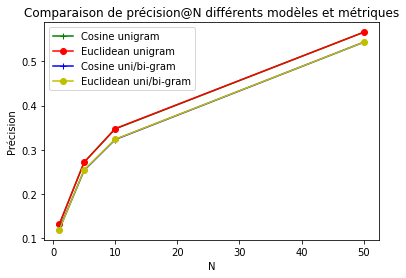

In [ ]:
# Affichage des résultats de la fonctions précédente
X = [1, 5, 10, 50]
plt.plot(X, precisions[0, :, 0], label = "Cosine unigram", color = "g", marker="+")
plt.plot(X, precisions[0, :, 1], label = "Euclidean unigram", color = "r", marker="o")
plt.plot(X, precisions[1, :, 0], label = "Cosine uni/bi-gram", color = "b", marker="+")
plt.plot(X, precisions[1, :, 1], label = "Euclidean uni/bi-gram", color = "y", marker="o")
plt.xlabel('N')
plt.ylabel('Précision')
plt.legend()
plt.title("Comparaison de précision@N différents modèles et métriques")
plt.show()

On observe que le meilleur modèle est le modèle M1. De plus, on voit que les mesures basées sur la distance cosinus et sur la distance euclidienne fournissent des résultats quasiment identiques.  
On observe de plus que le modèle est très mauvais pour des faibles valeurs de N. Même en top-50, aucun des deux modèles ne dépasse une précision de 0.6, on peut dire que ces modèles sont relativement limités.

3. (_5 points_) A cette étape, vous devez produire un fichier _passage_submission_M1.csv_ et _passage_submission_M2.csv_ qui contient pour toutes les questions de l’ensemble de test le top-N des passages retournés par votre modèle M1 et M2 pour y répondre. C’est à vous de déterminer si vous utiliserez la distance euclidienne ou cosinus basé sur vos résultats d’évaluation sur l’ensemble de validation en 1) et 2). Le fichier doit respecter le format suivant pour chaque top_N(N=1,5,10,50) :  <QuestionID, PassageID1 ;… ;PassageIDN>. Le format est démontré dans _sample_passage_submission.csv_.

In [ ]:
# Fonction qui calcule les résultats des modèles M1 et M2 avec la distance cosinus et les écrit dans les documents demandés
def write_predictions(N_list = (1,5,10,50), nb_subdiv=20, vocab_size=5000):
  N_max = max(N_list)
  t = time.time()
  t_ = time.time()
  for j in (2,1): # models
    print("Model M", j, sep="")
    #predictions_df = pd.DataFrame(np.zeros((validation_size, len(N_list))), columns=(["top-" + str(N) for N in N_list]))
    predictions = np.zeros((test_size, len(N_list)), dtype=object)
    #predictions_df.index.names = ["QuestionID"]
    vectorizer = TfidfVectorizer(ngram_range=(1,j), max_features=vocab_size)
    tfidf_model = vectorizer.fit_transform(corpus_complet_df["joined_lemmas"].values)
    corpus_tfidf = tfidf_model[:corpus_size]
    questions_tfidf = tfidf_model[corpus_size + train_size + validation_size: corpus_size + train_size + validation_size + test_size]
    del tfidf_model

    for subdiv in tqdm(range(nb_subdiv)):
      question_indices = np.array(list(range(subdiv * (test_size // nb_subdiv), (subdiv + 1) * (test_size // nb_subdiv))))
      similarities = cosine_similarity(questions_tfidf[question_indices], corpus_tfidf)
      predicted_indices = np.argsort(similarities, axis = 1)[:, -N_max:]
      #print(subdiv, question_indices)
      for i, N in enumerate(N_list):
        best_indices = predicted_indices[:,-N:]
        for m,index_question in enumerate(question_indices):
          predictions[index_question,i] = list(best_indices[m])
    predictions_df = pd.DataFrame(predictions, columns=["top-" + str(N) for N in N_list])
    predictions_df.index.names = ["QuestionID"]
    for N in N_list:
      predictions_df["top-" + str(N)].apply(lambda x: ";".join([str(elt) for elt in x]))
    print("Time:", time.time() - t, time.time()-t_)
    t_ = time.time()
    predictions_df.to_csv("./passage_submission_M{}.csv".format(j))
    print()
write_predictions()

Model M2


100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


Time: 65.66428303718567 65.66428470611572

Model M1


100%|██████████| 20/20 [00:35<00:00,  1.79s/it]


Time: 109.60821795463562 43.943732261657715



### 5.5. Le plus (24 points)



#### 1. (_21 points_) Vous devez proposer un modèle M3 différent (basé sur l’apprentissage machine par exemple) afin de déterminer un score de pertinence d’un passage pour une question donnée et ordonner les passages. 
    - Faites une petite recherche sur l’état de l’art en consultant https://nlp.stanford.edu/IR-book/information-retrieval-book.html
    - Vous êtes libres de proposer une autre métrique de poids, ou une autre façon d’ordonner les passages (exemple : méthodes de type _learning to rank_) et de partir de votre corpus initial ou de votre ordonnancement en M1/M2 (choisissez le meilleur) et de réordonnancer les passages obtenus par votre premier modèle.
    - Expliquez votre modèle et son intérêt dans votre notebook. Le nombre de points obtenus dépendra de l’effort mis dans cette partie.

Le modèle M3 que nous avons décidé de proposer est un modèle se basant sur l’algorithme Okapi BM25. Tout comme pour les modèles M1 et M2 il s’agit d’un modèle “Bag Of Words” mais qui utilise une métrique de poids différente de TF-IDF.

Dans ce modèle, étant donnée une question $q = [q_1, q_2, ..., q_n]$ où les $q_i$ sont les tokens de $q$ pré-traités, le poids accordé à un paragraphe $P$ est défini de la manière suivante :

$$
score(q,P) = \sum_{i=1}^nIDF(q_i)\frac{f(q_i,P) \times (k_1+1)}{f(q_i,P) + k_1(1-b+b \frac{Length(P)}{AvgLength})}
$$

On remarque que la métrique de BM25 ressemble beaucoup à la métrique TF-IDF mais elle comporte d'autres coefficients qui permettent de prendre en compte d'autres facteurs importants, tels que la longueur relative des paragraphes. 

Il faut cependant noter que la fonction $IDF$ qu'on voit dans la formule ne correspond pas à la métrique IDF définie pour les autres modèles. Elle est en effet définie comme suit :

$$
IDF(q_i) = ln(1 + \frac{nbParagraphs - f(q_i) +0.5}{f(q_i)+0.5})
$$

avec $f(q_i)$ le nombre de documents qui contiennent $q_i$. La définition utilisée n'est pas la même, mais elle permet toujours de pénaliser les termes trop communs, ceux qui apparaissent dans la plupart des paragraphes.


Les termes supplémentaires, et qui permettent d'apporter plus de précision au modèle, sont les suivants : 

- On voit d'abord apparaître le quotient $\frac{Length(P)}{AvgLength}$ qui représente le nombre de mots qui composent le paragraphe $P$ divisé par le nombre de mots moyen dans tous les paragraphes. Inclure ce terme au dénominateur permet de pénalisant les longs documents. En effet, on comprend intuitivement qu'un document de 1000 mots contenant un terme de notre question sera moins suceptible d'y répondre qu'un document de 20 mots contenant le même terme.

- La variable $b$ qui apparaît au dénominateur permet de choisir le poids du point prédédent. Plus $b$ sera choisi grand, plus la longueur d'un document relativement aux autres le pénalisera. Par défaut, on prendra $b=0.75$.

- Les termes $f(q_i,P)$ qui apparaissent au numérateur comme au dénominateur représente le nombre de fois que $q_i$ apparaît dans le paragraphe $P$. Ainsi, plus un terme apparaît dans un paragraphe, plus ce paragraphe est suceptible de contenir la réponse à la question correspondante.

- Enfin, le terme $k_1$, qui apparaît lui aussi au numérateur comme au dénominateur, va permettre de régler ce qu'on appelle la "saturation terme-fréquence". Il va limiter à quel point la fréquence d'un terme en particulier dans le paragraphe va influencer le score de ce paragraphe. De cette manière, pour un terme donné $q_i$, il y aura une grande différence de score entre un document qui contient une fois $q_i$ et un document qui le contient 10 fois, mais une faible différence entre un documents qui le comporte 10 et fois et un qui le comporte 20 fois. $k_1$ correspond à peu près au seuil de fréquence à partir duquel une augmentation de fréquence bénéficiera de moins en moins au score.  
  
Nous allons maintenant écrire des fonctions pour mesurer les performances de ce modèle suivant son implémentation par le module python `rank_bm25`


##### importation des libraires

In [ ]:
# installation du module que nous allons utiliser
! pip install rank_bm25

In [ ]:
from rank_bm25 import BM25Okapi

##### prétraitement des données 
dans cette partie on a décidé d'utiliser les données réduits pour simplifier nos tests. Nous n'utiliserons que les données de test et de validation nous ne sommes pas dans le cadre d'un modèle de machine learning

In [ ]:
# Récupération des données de test réduit
test_reduced_df = pd.read_csv("./data/test_reduced.csv")
test_complet = corpus_complet_df[['id_test','tokens']].dropna()
test_complet.index = test_complet["id_test"]
test_M3 = test_complet.loc[test_reduced_df["id"].values]
test_M3

,id_test,tokens
id_test,,
9030,9030.0,"[sings, song, loved]"
2651,2651.0,"[happens, event, tie]"
3014,3014.0,"[cause, sugar, created, chlorophyll, breakdown]"
6652,6652.0,"[bo, end, lost, girl]"
3544,3544.0,"[exaple, hepatonic, scale]"
...,...,...
5507,5507.0,"[temperature, diesel, fuel, start, jail]"
3785,3785.0,"[pattern, come]"
8723,8723.0,"[old, go, gun, range, massachusetts]"


In [ ]:
# On prétraite à nouveau les question de l'ensemble de validation réduit car on n'a pas leurs ids
validation_reduced_df = pd.read_csv("./data/val_reduced.csv")
validation_reduced_df['question_html_free'] = validation_reduced_df['question'].apply(remove_html)
validation_reduced_df['pre_tokens'] = validation_reduced_df['question_html_free'].apply(word_tokenize)
validation_reduced_df['lower_case'] = validation_reduced_df['pre_tokens'].apply(lower_case)
validation_reduced_df['no_stopwords'] = validation_reduced_df['lower_case'].apply(rm_stopwords)
validation_reduced_df['tokens'] = validation_reduced_df['no_stopwords'].apply(lemmatize)
validation_reduced_df.head(5)

,question,paragraph_id,answer,question_html_free,pre_tokens,lower_case,no_stopwords,tokens
0,What religious group was in charge of Rome's s...,18945.0,Vestals,What religious group was in charge of Rome's s...,"[What, religious, group, was, in, charge, of, ...","[what, religious, group, was, in, charge, of, ...","[religious, group, charge, rome, 's, sacred, f...","[religious, group, charge, rome, 's, sacred, f..."
1,when did delhi became an important commercial ...,35574.0,12th century,when did delhi became an important commercial ...,"[when, did, delhi, became, an, important, comm...","[when, did, delhi, became, an, important, comm...","[delhi, became, important, commercial, centre]","[delhi, became, important, commercial, centre]"
2,when does the first cardcaptor movie take place,50554.0,between the first and second seasons of the te...,when does the first cardcaptor movie take place,"[when, does, the, first, cardcaptor, movie, ta...","[when, does, the, first, cardcaptor, movie, ta...","[first, cardcaptor, movie, take, place]","[first, cardcaptor, movie, take, place]"
3,who was the first speaker of the lok sabha,20802.0,Ganesh Vasudev Mavlankar,who was the first speaker of the lok sabha,"[who, was, the, first, speaker, of, the, lok, ...","[who, was, the, first, speaker, of, the, lok, ...","[first, speaker, lok, sabha]","[first, speaker, lok, sabha]"
4,one of the problems when doing requirements de...,81070.0,conflicting requirements of the various stakeh...,one of the problems when doing requirements de...,"[one, of, the, problems, when, doing, requirem...","[one, of, the, problems, when, doing, requirem...","[one, problems, requirements, determination]","[one, problem, requirement, determination]"


##### Définition du modèle et des différentes fonction d'évaluation

In [ ]:
# Création de l'objet BM25
bm25 = BM25Okapi(corpus_complet_df['tokens'].loc[:corpus_size]) #corpus traité sans les questions

In [ ]:
# Calcule le top-N pour une question donnée avec le modèle BM25
def bm25_topN(questions_token, corpus_para_ids, N):
  '''
  input :
  N : number of answers selected with the best bm25 score
  questions : array of querys in token format
  corpus_para_ids : array of the paragraph ids in the whole corpus

  output :
  tab_topN : array of the topN for each query
  N : number of answers selected with the best bm25 score
  '''
  tab_topN = []
  nb_questions = len(questions_token)
  print("Generate bm25 top-N")
  for i in tqdm(range(nb_questions)):
    question_i_TOP_N = bm25.get_top_n(questions_token[i], corpus_para_ids, n=N)
    tab_topN.append(question_i_TOP_N)
  return tab_topN , N

In [ ]:
# Calcule la précision@N du modèle
def bm25_accuracy(answer_para_id, tab_top_N_max, N):
  '''
  input :
  answer_para_id : array of the paragraph ids of the answers to the question (available on train and validation set)
  tab_top_N : array of top N for each question 

  output :
  accuracy : accuracy of bm25 ragrding the topN, ie the number of time an answer is in the correponding predicted topN
  N : number of answers selected with the best bm25 score
  '''
  accuracy=0
  print("Compute accuracy")
  for index_query in tqdm(range(len(tab_top_N_max))) :
    #progress.update(100)
    answer_i = answer_para_id[index_query]
    if answer_i in tab_top_N_max[index_query][:N]:
      accuracy +=1
  accuracy = accuracy/len(tab_top_N_max )
  return accuracy, N

In [ ]:
# Calcule l'ensemble des précisions du model pour différents top-N
def performance(questions_token, corpus_para_ids, answer_para_id):
  '''
  plot the accuracy of bm25 for different N =[1, 5, 10, 50]
  '''

  X = [1, 5, 10, 50]
  Y = []
  tab_top_N, N = bm25_topN(questions_token, corpus_para_ids,max(X))
  for value in X:
    print(f'Top-{value}')
    accuracy_N, N = bm25_accuracy(answer_para_id, tab_top_N, value)
    Y.append(accuracy_N)
  '''
  plt.plot(X, Y, label = "bm25", color = "r", marker="+")
  plt.xlabel('N')
  plt.ylabel('accuracy')
  plt.legend()
  '''
  return Y

#### 2. (_2  point_) Vous devez ensuite afficher l’évaluation de votre modèle M3 tel que décrit dans la section 5.4 Evaluation en utilisant les mêmes fonctions. Notamment, vous devez comparer les performances de vos modèles M1, M2 et M3 sur l’ensemble de validation avec une courbe de performance faisant varier le N (N=1, 5, 10, …)

In [ ]:
# Préparation des données pour les statistiques du modèle BM25 et application des fonctions précédentes
corpus_to_test = corpus_complet_df.loc[:corpus_size]
corpus_para_ids=corpus_to_test.iloc[:,0]
Y_M3 = performance(validation_reduced_df["tokens"], corpus_para_ids, validation_reduced_df["paragraph_id"])

Generate bm25 top-N


100%|██████████| 1000/1000 [03:21<00:00,  4.96it/s]


Top-1
Compute accuracy


100%|██████████| 1000/1000 [00:00<00:00, 109417.58it/s]


Top-5
Compute accuracy


100%|██████████| 1000/1000 [00:00<00:00, 108256.87it/s]


Top-10
Compute accuracy


100%|██████████| 1000/1000 [00:00<00:00, 87886.68it/s]


Top-50
Compute accuracy


100%|██████████| 1000/1000 [00:00<00:00, 82101.20it/s]


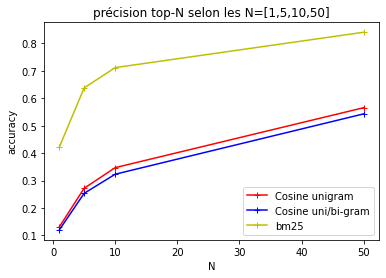

In [ ]:
# Affichage de la comparaison avec les modèles M1 et M2
plt.plot(X, precisions[0, :, [0]][0], label = "Cosine unigram", color = "r", marker="+")
plt.plot(X, precisions[1, :, [0]][0], label = "Cosine uni/bi-gram", color = "b", marker="+")
plt.plot(X, Y_M3, label = "bm25", color = "y", marker="+")
plt.title('précision top-N selon les N=[1,5,10,50]')
plt.xlabel('N')
plt.ylabel('accuracy')
plt.legend()

On observe, que BM25 donne de meilleurs résultats que le modèle M1 et M2 avec une précision TOP50 s'approchant de 0,9. Cependant, on ne contrôle pas la taille du vocabulaire utilisé par le modèle BM25, on va donc le comparer avec les modèles M1 et M2 en modifiant la taille de leur vocabulaire pour voir si on observe une tendance qui pourrait indiquer qu'un vocabulaire suffisamment grand permettrait à M1 et M2 de battre M3.

In [ ]:
# Création des générateurs de modèle de différentes tailles de vocabulaire pour la fonction `test_precisions` et application de la fonction
vocab_sizes = (500, 5000, 10000, 50000)
models = [lambda : tfidf_model_generator((1,1), vocab_sizes[0]), lambda : tfidf_model_generator((1,2), vocab_sizes[0]), 
          lambda : tfidf_model_generator((1,1), vocab_sizes[1]), lambda : tfidf_model_generator((1,2), vocab_sizes[1]), 
          lambda : tfidf_model_generator((1,1), vocab_sizes[2]), lambda : tfidf_model_generator((1,2), vocab_sizes[2]), 
          lambda : tfidf_model_generator((1,1), vocab_sizes[3]), lambda : tfidf_model_generator((1,2), vocab_sizes[3])]
precisions_compare_sizes = test_precision((cosine_similarity,), models)

Model 1 / n_grams : (1, 1)  / vocabulary size : 500
Model vectorization done in 6s
Distance  1 --> 

100%|██████████| 20/20 [00:26<00:00,  1.32s/it]



Model 2 / n_grams : (1, 2)  / vocabulary size : 500
Model vectorization done in 30s
Distance  1 --> 

100%|██████████| 20/20 [00:26<00:00,  1.31s/it]



Model 3 / n_grams : (1, 1)  / vocabulary size : 5000
Model vectorization done in 6s
Distance  1 --> 

100%|██████████| 20/20 [00:28<00:00,  1.42s/it]



Model 4 / n_grams : (1, 2)  / vocabulary size : 5000
Model vectorization done in 30s
Distance  1 --> 

100%|██████████| 20/20 [00:28<00:00,  1.42s/it]



Model 5 / n_grams : (1, 1)  / vocabulary size : 10000
Model vectorization done in 6s
Distance  1 --> 

100%|██████████| 20/20 [00:28<00:00,  1.43s/it]



Model 6 / n_grams : (1, 2)  / vocabulary size : 10000
Model vectorization done in 30s
Distance  1 --> 

100%|██████████| 20/20 [00:28<00:00,  1.45s/it]



Model 7 / n_grams : (1, 1)  / vocabulary size : 50000
Model vectorization done in 6s
Distance  1 --> 

100%|██████████| 20/20 [00:29<00:00,  1.47s/it]



Model 8 / n_grams : (1, 2)  / vocabulary size : 50000
Model vectorization done in 30s
Distance  1 --> 

100%|██████████| 20/20 [00:30<00:00,  1.51s/it]

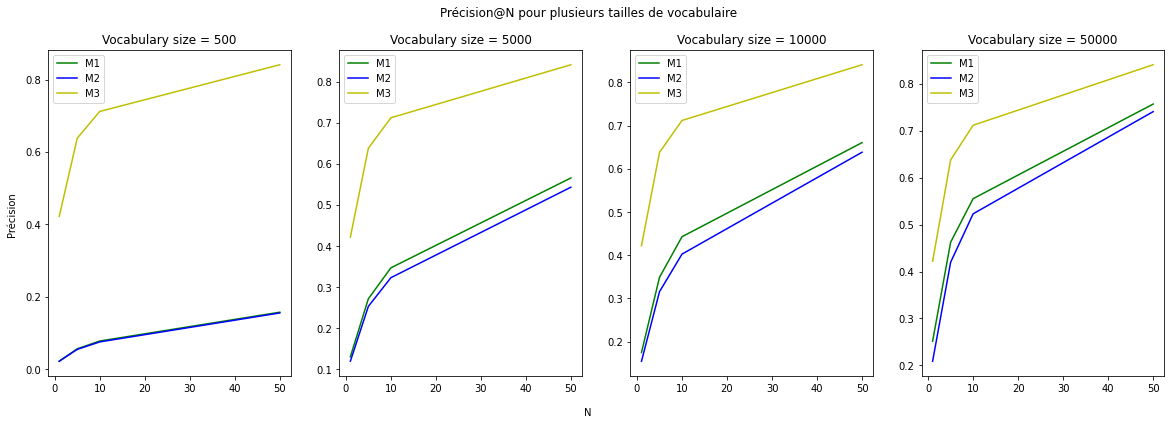

In [ ]:
# Affichage des résultats
f, axes = plt.subplots(1, len(vocab_sizes), sharex=True, figsize=(20,6))
f.suptitle('Précision@N pour plusieurs tailles de vocabulaire')
for i, size in enumerate(vocab_sizes): 
  axes[i].plot(X, precisions_compare_sizes[2*i, :, 0], label = "M1", color = "g")
  axes[i].plot(X, precisions_compare_sizes[2*i+1, :, 0], label = "M2", color = "b")
  axes[i].plot(X, Y_M3, label = "M3", color = "y")
  axes[i].set_title(f"Vocabulary size = {vocab_sizes[i]}")
  axes[i].legend()
#plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
#plt.xlabel("N")
#plt.ylabel("Précision")
f.text(0.5, 0.04, 'N', va='center', ha='center')
f.text(0.1, 0.5, 'Précision', va='center', ha='center', rotation='vertical')
plt.show()

On observe que les modèles M1 et M2 sont en effet plus performants avec un vocabulaire plus conséquent. Cependant, il semble y avoir un cap de performance à partir duquel l'augmentation de la taille du vocabulaire ne suffit pas à augmenter les performances.  
De plus on observe également que le modèle M1 semble s'améliorer plus vite que M2 en augmentant la taille du vocabulaire, ce qui est contre intuitif. Il semblerait que pour cette tache, la présence de bigramme ne soit pas utile.

#### 3. (_1 point_) En utilisant votre modèle M3, vous devez produire un fichier passage_submission_M3.csv qui contient pour toutes les questions de l’ensemble de test le top-N des passages retournés par votre système pour y répondre. Le fichier doit respecter le format suivant pour chaque top_N (N=1,5,10,50) :  <QuestionID, PassageID1…PassageIDN>. _Le format est démontré dans sample_passage_submission.csv_

In [ ]:
# Fonction pour sauvegarder les résultats du modèle M3
def submission(questions_token, corpus_para_ids, set_size, N_list = (1,5,10,50)):
  N_max = max(N_list)
  predictions_df = pd.DataFrame(np.zeros((corpus_size, len(N_list))), columns=(["top-" + str(N) for N in N_list]))
  predictions_df.index.names = ["QuestionID"]
    
  tab_top_N, _ = bm25_topN(questions_token, corpus_para_ids,N_max)
  
  for i, N in enumerate(N_list):
    for question_index in range(set_size):
      best_indices = tab_top_N[question_index][:N]
      predictions_df["top-" + str(N)][question_index] = ";".join([str(elt) for elt in best_indices])
  predictions_df.to_csv("./passage_submission_M3.csv")

In [ ]:
test_questions_token = test_M3['tokens'].values
test_set_size = len(test_questions_token)

submission(test_questions_token, corpus_para_ids, test_set_size, N_list = (1,5,10,50))

Generate bm25 top-N


100%|██████████| 1000/1000 [03:19<00:00,  5.02it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
print("Temps total d'exécution : ", int((time.time() - t_init)/60), "min", sep='')

Temps total d'exécution : 28min


## Conclusion du TP

Au cours de ce tp nous avons pu réaliser les différents traitements de textes (lemming, stemming, suppression des stops words etc...) et comparer 3 modèles bag of words avec des mesure de distance différentes. Finalement, Le modèle bm25, nous donne les meilleurs précisions topN. Nous avons également été confronté aux problèmes d'explosion de RAM du à nos tailles de données. Notamment nous avons pu voir comment optimiser le temps d'éxecution de nos algorithmes (via des calculs matricielles ici). Ce qui nous permet d'éxecuter notre notebook en à peu près 30 minutes.

## LIVRABLES
Vous devez remettre sur Moodle:
1. _Le code_ : Un Jupyter notebook en Python qui contient le code implanté avec les librairies permises. Le code doit être exécutable sans erreur et accompagné des commentaires appropriés dans le notebook de manière à expliquer les différentes fonctions et étapes dans votre projet. Nous nous réservons le droit de demander une démonstration ou la preuve que vous avez effectué vous-mêmes les expériences décrites. _Attention, en aucun cas votre code ne doit avoir été copié d’une quelconque source_. Les critères de qualité tels que la lisibilité du code et des commentaires sont importants. Tout votre code et vos résultats doivent être exécutables et reproductibles ; 
2. Un fichier _requirements.txt_ doit indiquer toutes les librairies / données nécessaires ;
3. Un lien _GoogleDrive_ ou similaire vers les modèles nécessaires pour exécuter votre notebook si approprié ;
4. Les fichiers de soumission de données de test _passage_submission_M1.csv_ et _passage_submission_M2.csv_
5. Un document _contributions.txt_ : Décrivez brièvement la contribution de chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. En particulier, tous les membres du projet devraient participer à la conception du TP et participer activement à la réflexion et à l’implémentation du code.

## EVALUATION 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code
2. Performance correcte des modèles
3. Organisation du notebook
4. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
5. Commentaires clairs et informatifs

## CODE D’HONNEUR
- Règle 1:  Le plagiat de code est bien évidemment interdit.
- Règle 2: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- Règle 3:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.


pour convertir le .ipynb en .html

In [ ]:
'''
%%shell
jupyter nbconvert --to html /content/TP1_lab02_05.ipynb
'''

[NbConvertApp] Converting notebook /content/TP1_lab02_05.ipynb to html
[NbConvertApp] Writing 592490 bytes to /content/TP1_lab02_05.html
